In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import SimpleITK as sitk
import numpy as np
from supporters import *
from scipy.ndimage import zoom

### Load network and pretrained model to copy weights

In [2]:
from networks.dense_feature_extraction import Dense
from networks.linear_embedding import LinearEmbedding
from networks.transformer import Transformer
from networks.rotatory_attention import RotatoryAttention
from networks.recon import Reconstruction
from networks.uct_decoder import UCTDecoder
from networks.config import get_config

In [3]:
model_path = 'outputs\RotCAtt_TransUNet_plusplus\VHSCDD_RotCAtt_TransUNet_plusplus_bs6_ps16_epo600_hw512_ly4\model.pth'
trained_model = torch.load(model_path)

In [ ]:
# Get cofig and instance
config = get_config() 
dense_feature_extraction = Dense(config).cuda()
linear_embedding = LinearEmbedding(config).cuda()
transformer = Transformer(config).cuda()
rotatory_attention = RotatoryAttention(config).cuda()
reconstruct = Reconstruction(config).cuda()
decoder = UCTDecoder(config).cuda()

# define state dict
dense_state_dict = dense_feature_extraction.state_dict()
embedding_state_dict = linear_embedding.state_dict()
transformer_state_dict = transformer.state_dict()
rot_state_dict = rotatory_attention.state_dict()
recon_state_dict = reconstruct.state_dict()
decoder_state_dict = decoder.state_dict()

for name, param in trained_model.state_dict().items():
    if name.startswith('dense'):
        dense_state_dict[name[len("dense."):]].copy_(param)
    elif name.startswith('linear_embedding'):
        embedding_state_dict[name[len("linear_embedding."):]].copy_(param)
    elif name.startswith('transformer'):
        transformer_state_dict[name[len('transformer.'):]].copy_(param)
    elif name.startswith('rotatory_attention'):
        rot_state_dict[name[len('rotatory_attention.'):]].copy_(param)
    elif name.startswith('reconstruct'):
        recon_state_dict[name[len('reconstruct.'):]].copy_(param)
    elif name.startswith('decoder'):
        decoder_state_dict[name[len('decoder.'):]].copy_(param)

dense_feature_extraction.eval()
linear_embedding.eval()
transformer.eval()
rotatory_attention.eval()
rotatory_attention.eval()
reconstruct.eval()
decoder.eval()

### Load sample data to explore

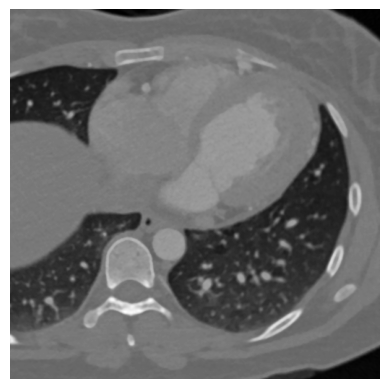

In [4]:
image = sitk.GetArrayFromImage(sitk.ReadImage('data/VHSCDD_512/test_images/0001.nii.gz'))
slice = image[152]
plt.axis('off')
plt.imshow(slice, cmap='gray')

In [5]:
batch_size = 6
input = image[150:156,:,:]
input_torch = torch.tensor(input).to(torch.float32).unsqueeze(1).cuda()
input_torch.size()

torch.Size([6, 1, 512, 512])

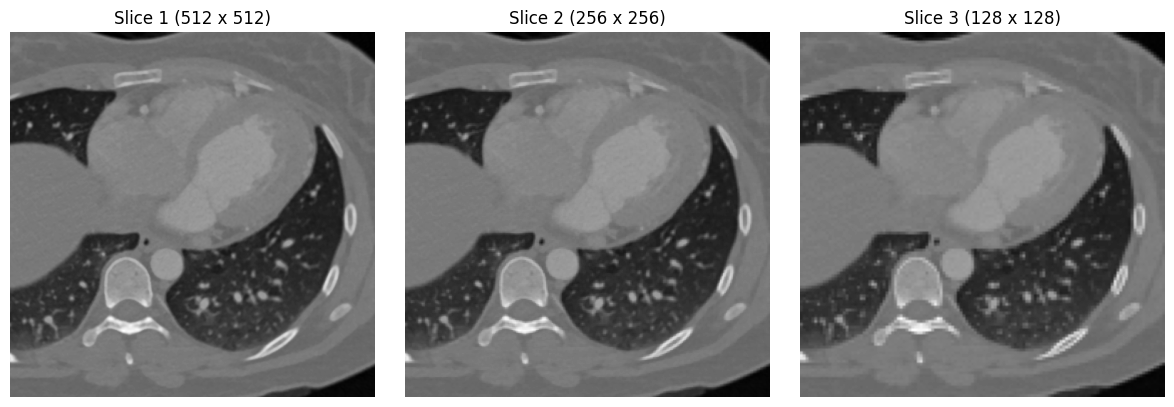

In [7]:
# target slices for visualization
slice_1 = input[2]
slice_2 = zoom(slice_1, (1/2, 1/2), order=0)
slice_3 = zoom(slice_1, (1/4, 1/4), order=0)

slices = [slice_1, slice_2, slice_3]
titles = ['Slice 1 (512 x 512)', 'Slice 2 (256 x 256)', 'Slice 3 (128 x 128)']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, (slice_data, title) in enumerate(zip(slices, titles)):
    axs[i].imshow(slice_data, cmap='gray')
    axs[i].set_title(title)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### Patches localization

In [8]:
def patch_localization(patch_indices=None, patch_size=None, slice=None):
    plt.imshow(slice, cmap='gray')  

    for patch_index in patch_indices:
        patch_row = patch_index // (slice.shape[1] // patch_size)
        patch_col = patch_index % (slice.shape[1] // patch_size)
        
        bbox_x = patch_col * patch_size
        bbox_y = patch_row * patch_size
        bbox_width = patch_size
        bbox_height = patch_size

        rect = patches.Rectangle((bbox_x, bbox_y), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    plt.axis('off')
    plt.show()

### Dense Feature Extraction

In [9]:
x1, x2, x3, x4 = dense_feature_extraction(input_torch)
x1.size(), x2.size(), x3.size(), x4.size()

(torch.Size([6, 64, 512, 512]),
 torch.Size([6, 128, 256, 256]),
 torch.Size([6, 256, 128, 128]),
 torch.Size([6, 256, 64, 64]))

In [10]:
def detach(x):
    return x.detach().cpu().numpy()[2]  # get the center slice

np_x1 = detach(x1)
np_x2 = detach(x2)
np_x3 = detach(x3)

np_x1.shape, np_x2.shape, np_x3.shape

((64, 512, 512), (128, 256, 256), (256, 128, 128))

#### Visualize feature maps $X_i$ at different scale level $i$-th

In [11]:
# only first 64 feature maps
def visualize_feature_maps(x):
    n = 8
    _, axs = plt.subplots(n, n, figsize=(12,12))
    axs = axs.ravel()

    for i in range(n * n):
        axs[i].imshow(x[i], cmap='gray')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

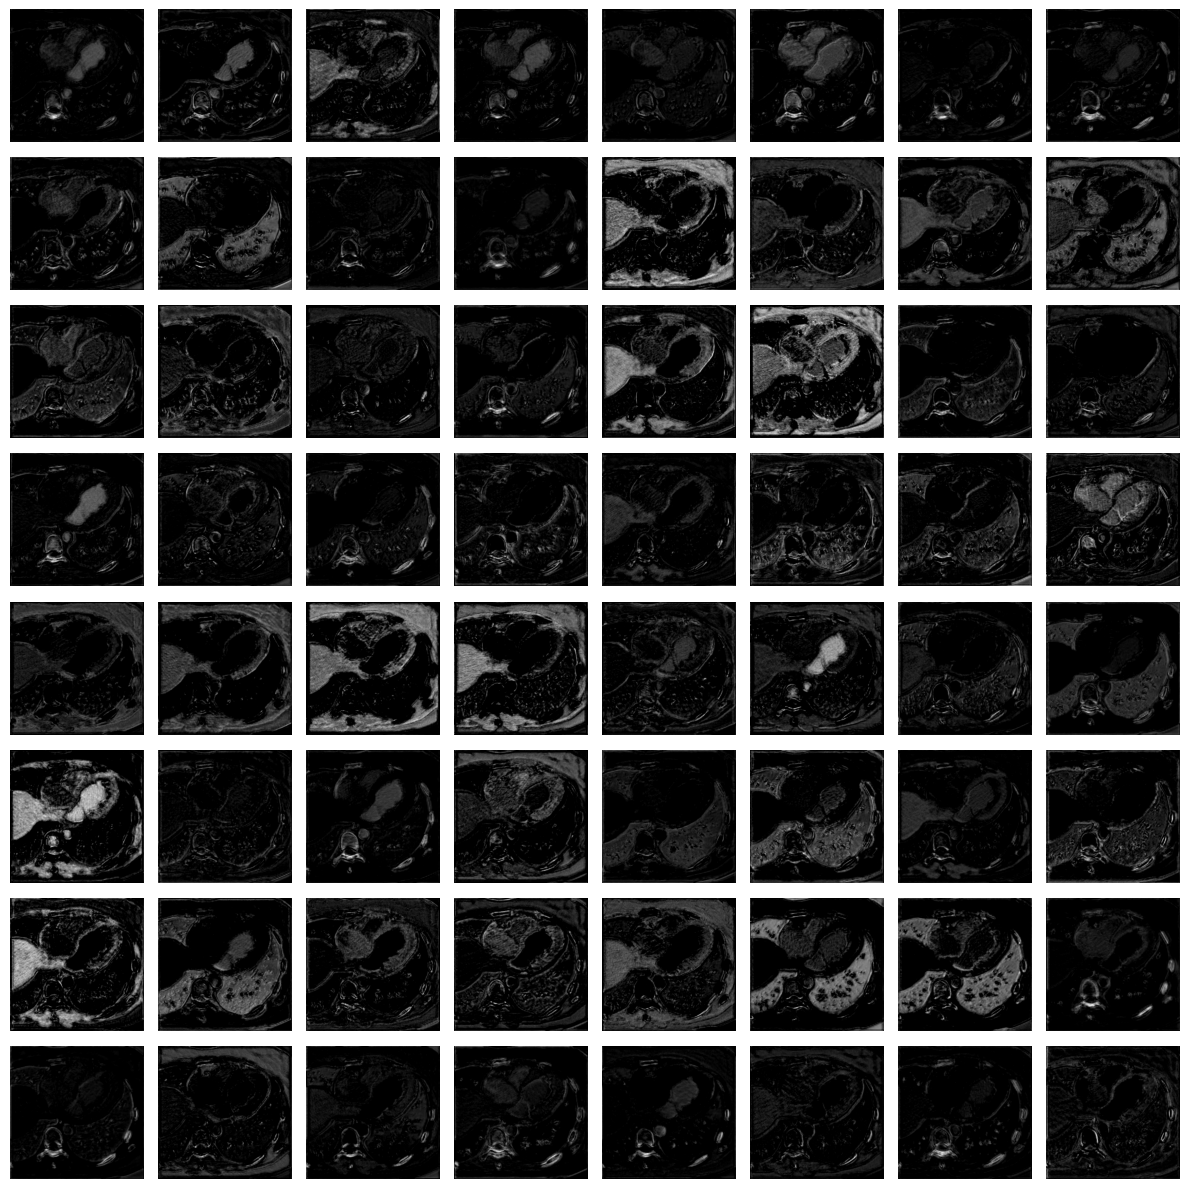

In [12]:
# Scale 1
visualize_feature_maps(np_x1)

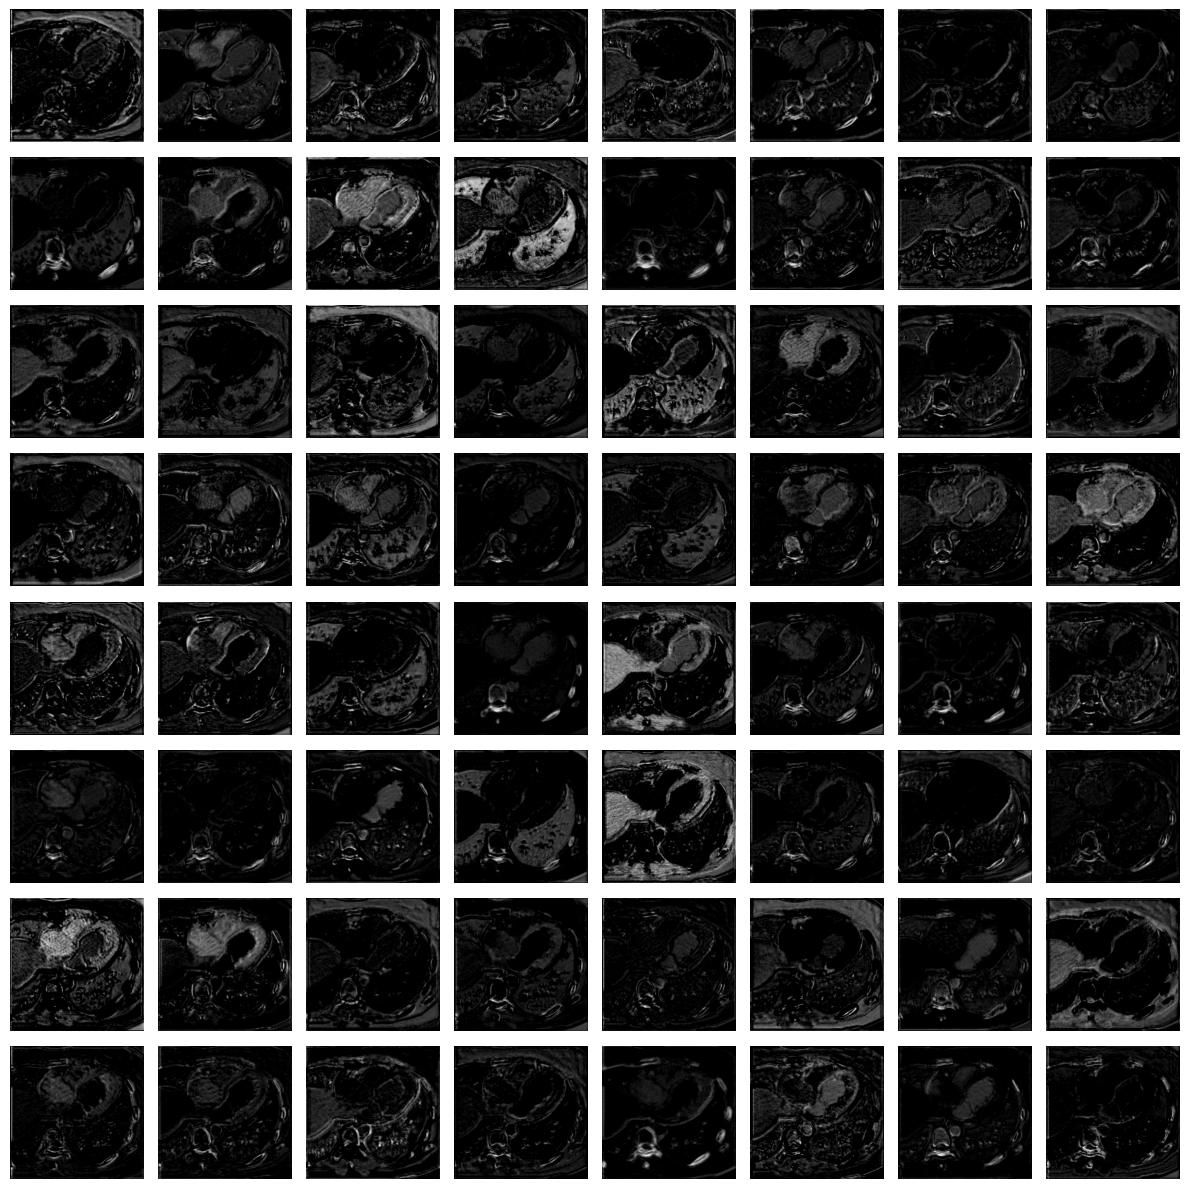

In [13]:
# Scale 2
visualize_feature_maps(np_x2)

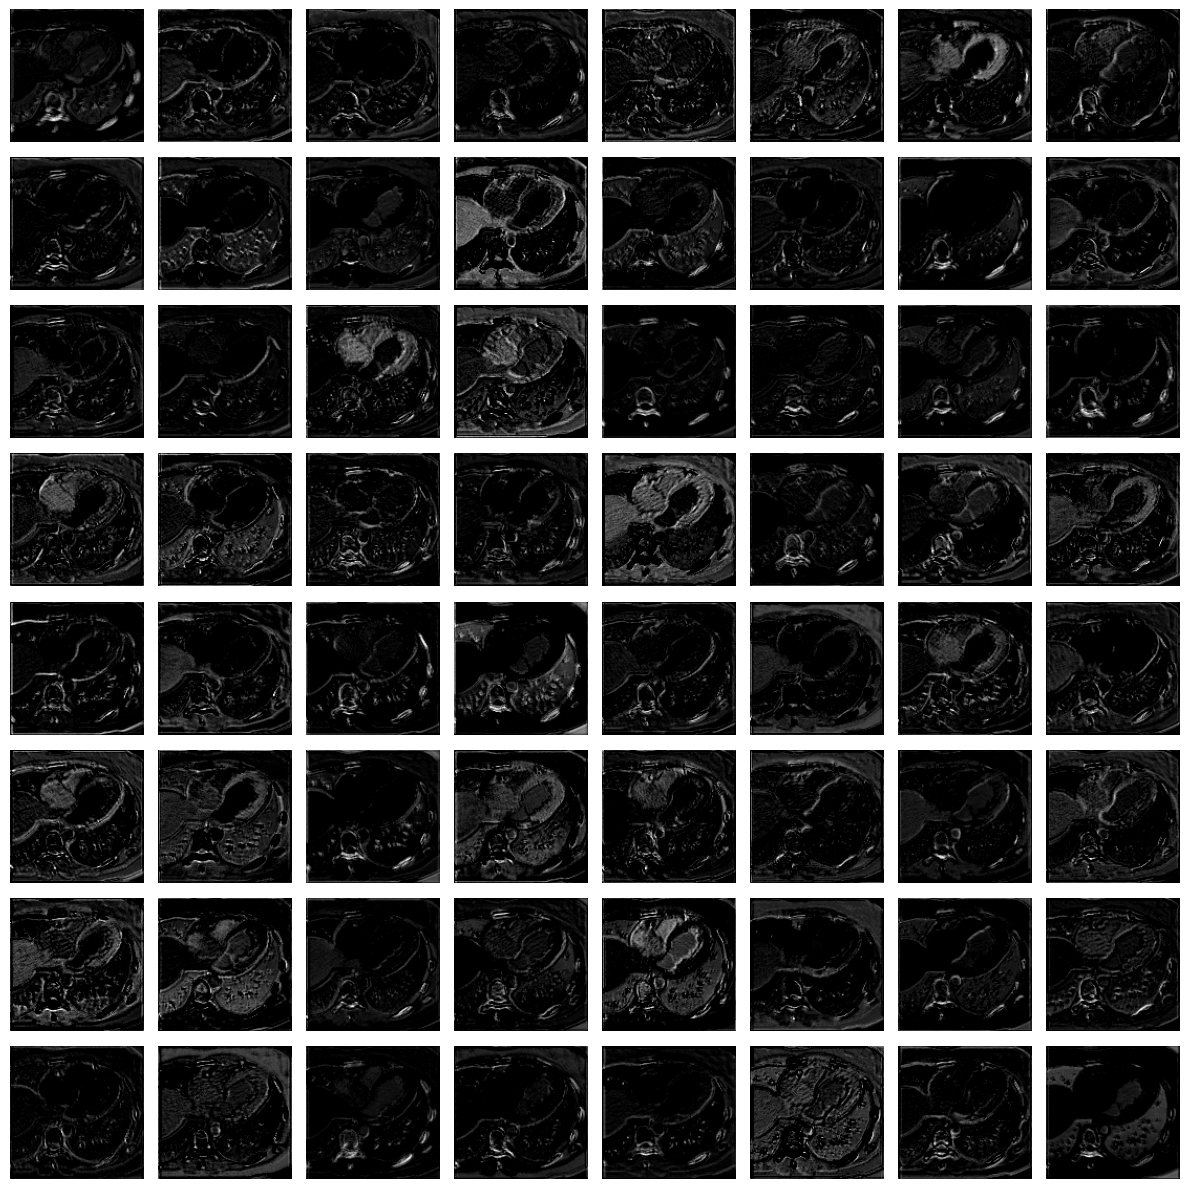

In [14]:
# Scale 3
visualize_feature_maps(np_x3)

### Visualize $X_i$ as one feature map to represent all all feature maps

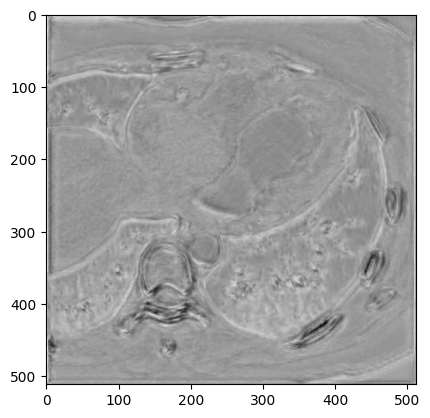

In [13]:
conv1 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1).cuda()
recon_x1 = conv1(x1)
np_recon_x1 = recon_x1.detach().cpu().numpy()[2].squeeze(0)
plt.imshow(np_recon_x1, cmap='gray')

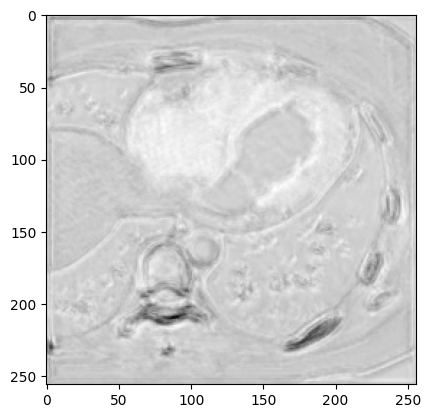

In [16]:
conv2 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1).cuda()
recon_x2 = conv2(x2)
np_recon_x2 = recon_x2.detach().cpu().numpy()[2].squeeze(0)
plt.imshow(np_recon_x2, cmap='gray')

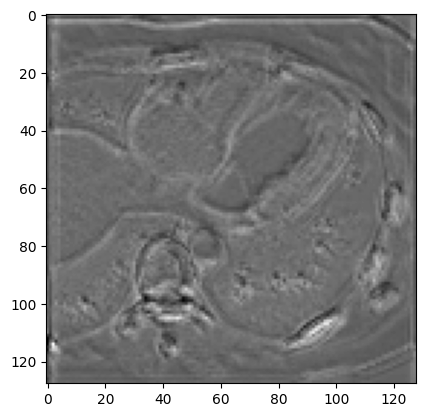

In [17]:
conv3 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, padding=1).cuda()
recon_x3 = conv3(x3)
np_recon_x3 = recon_x3.detach().cpu().numpy()[2].squeeze(0)
plt.imshow(np_recon_x3, cmap='gray')

### Linear & Positional Embedding

In [13]:
z1, z2, z3 = linear_embedding(x1, x2, x3)
z1.size(), z2.size(), z3.size()

(torch.Size([6, 1024, 64]),
 torch.Size([6, 1024, 128]),
 torch.Size([6, 1024, 256]))

In [19]:
np_z1 = detach(z1)
np_z2 = detach(z2)
np_z3 = detach(z3)
np_z1.shape, np_z2.shape, np_z3.shape

((1024, 64), (1024, 128), (1024, 256))

#### Visualize feature embeddings $Z_i$

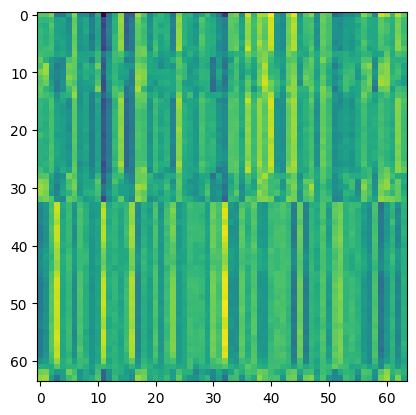

In [20]:
# size 1
start_token = 0
end_token = 64
start_feature = 0
end_feature = 64 
plt.imshow(np_z1[start_token:end_token, start_feature:end_feature])

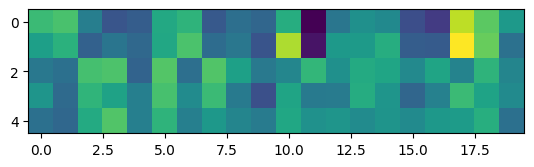

In [21]:
# size 1
start_token = 200
end_token = 205
start_feature = 0
end_feature = 20
plt.imshow(np_z1[start_token:end_token, start_feature:end_feature])

### Transformer block

In [14]:
e1, e2, e3, z1_list, z2_list, z3_list, a1_weights, a2_weights, a3_weights, c1_weights, c2_weights, c3_weights = transformer(z1, z2, z3)
e1.shape, e2.shape, e3.shape

(torch.Size([6, 1024, 64]),
 torch.Size([6, 1024, 128]),
 torch.Size([6, 1024, 256]))

#### Visualize how feature embeddings of vectorize patches change through layers of Transformer

In [15]:
def vis_trans_layers(image_list, start_token=512, end_token=522, start_feature=0, end_feature=64):
    num_images = len(image_list)
    _, axs = plt.subplots(1, num_images, figsize=(20, 20)) 
    for i, image in enumerate(image_list):
        axs[i].imshow(detach(image)[start_token:end_token, start_feature:end_feature])  
        axs[i].axis('off')
    plt.show()

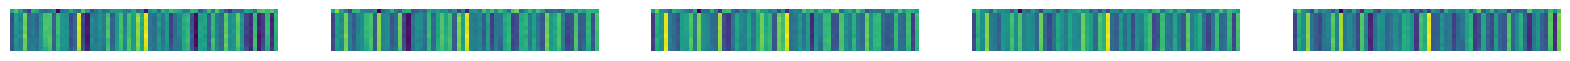

In [34]:
vis_trans_layers(z1_list)

#### Visualize attention weights through layers across num_heads

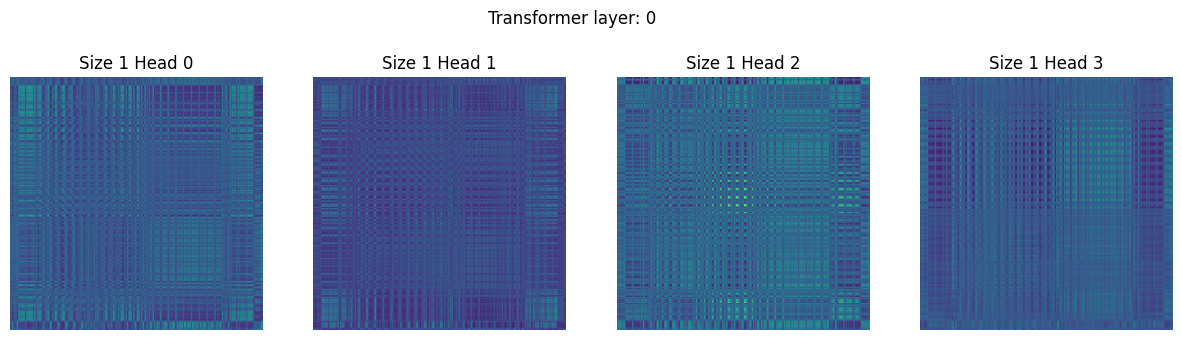

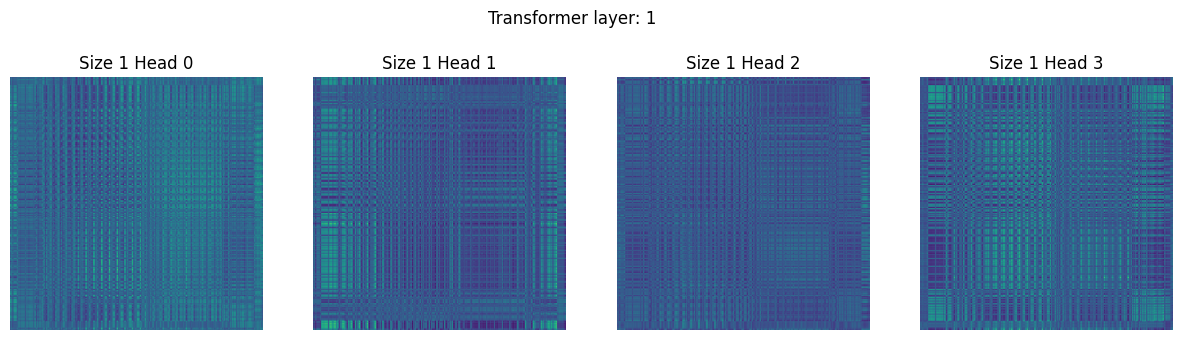

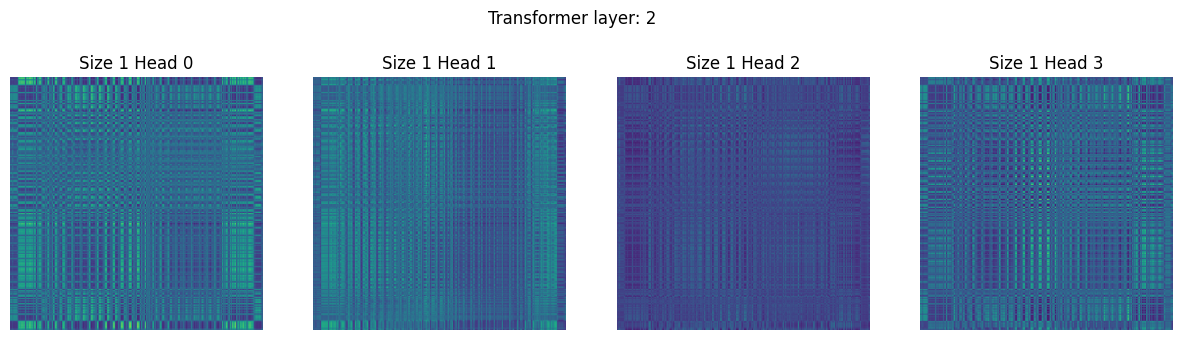

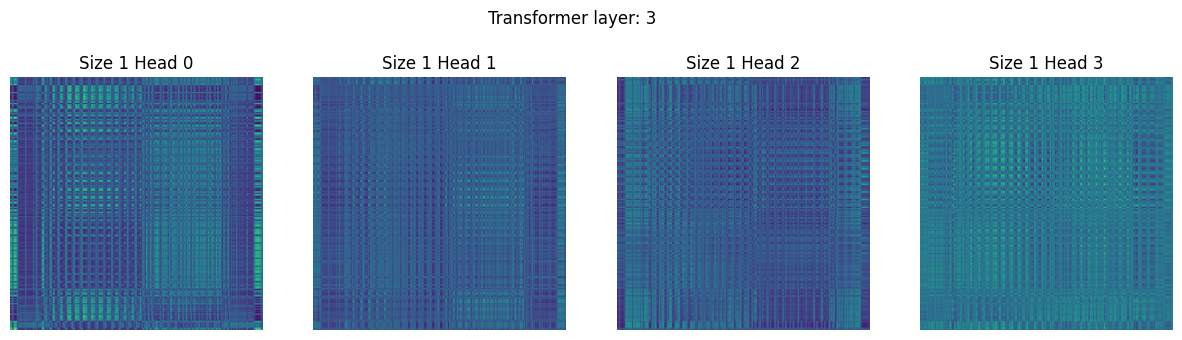

In [169]:
for l in range(config.num_layers):
    attention_weights = detach(a1_weights[l])
    fig, axs = plt.subplots(1, config.num_heads, figsize=(15,4))
    plt.suptitle(f'Transformer layer: {l}')
    for h in range(attention_weights.shape[0]):
        axs[h].set_title(f'Size 1 Head {h}')
        axs[h].imshow(attention_weights[h])
        axs[h].axis('off') 
plt.show()

#### Interpret attention weights more closely

Ajust the layer index, head index and adjust filter to visualize patches

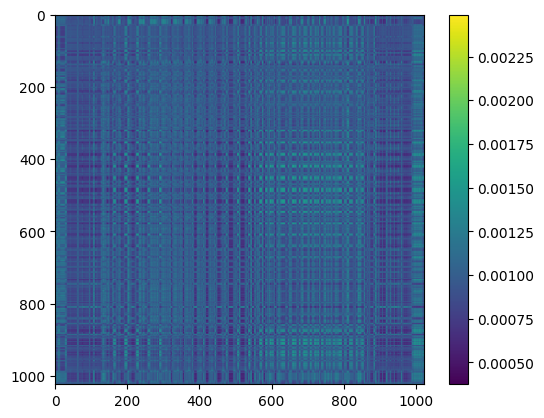

In [148]:
l = 3
h = 1
a = detach(a1_weights[l])[h]
plt.imshow(a)
plt.colorbar()

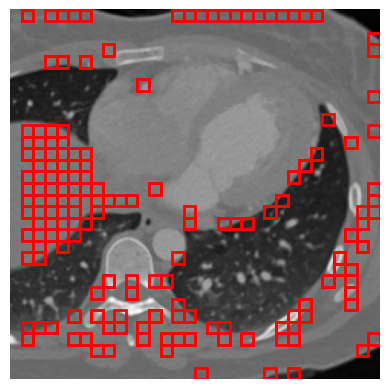

In [152]:
# filter the patches that have high similarity 
indices = np.where(a >= 0.00178)
indices_x = indices[0]
indices_y  = indices[1]
patch_indices = np.concatenate((indices_x, indices_y)).tolist()
patch_localization(patch_size=16, patch_indices=patch_indices, slice=slice_1)

#### Visualize the context weights through layers

In [157]:
context = detach(c1_weights[0])
context.shape

(1024, 64)

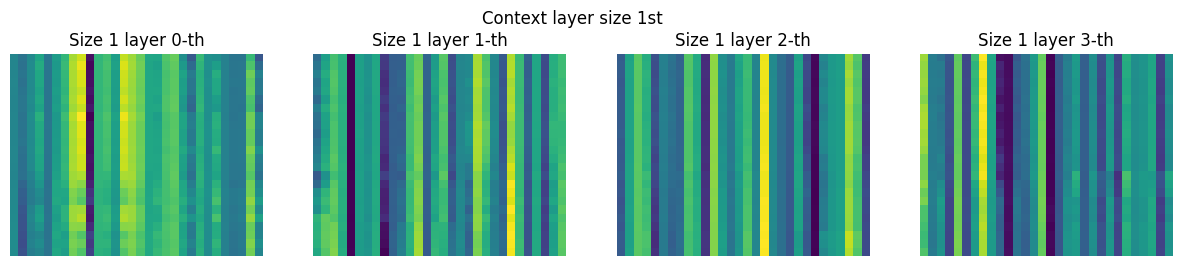

In [168]:
fig, axs = plt.subplots(1, config.num_layers, figsize=(15,3))
plt.suptitle('Context layer size 1st')
for l in range(config.num_layers):
    context = detach(c1_weights[l])
    axs[l].set_title(f'Size 1 layer {l}-th')
    axs[l].imshow(context[1000:1024, 30:60])
    axs[l].axis('off')
plt.show()

### Explore how $R$ affect feature embeddings

In [16]:
r1, r2, r3 = rotatory_attention(z1, z2, z3)
r1.size(), r2.size(), r3.size()

(torch.Size([1, 1, 64]), torch.Size([1, 1, 128]), torch.Size([1, 1, 256]))

In [26]:
np_r1 = r1[0,:,:].detach().cpu().numpy()
np_r2 = r2[0,:,:].detach().cpu().numpy()
np_r3 = r3[0,:,:].detach().cpu().numpy()

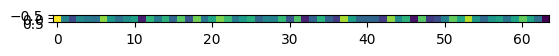

In [23]:
plt.imshow(np_r1)

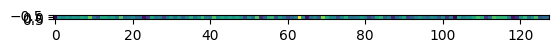

In [24]:
plt.imshow(np_r2)

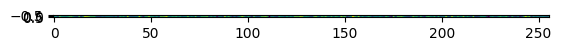

In [27]:
plt.imshow(np_r3)

In [31]:
f1 = e1 + z1
f2 = e2 + z2
f3 = e3 + z3

f1.size(), f2.size(), f3.size()

(torch.Size([6, 1024, 64]),
 torch.Size([6, 1024, 128]),
 torch.Size([6, 1024, 256]))

Text(0.5, 1.0, 'After')

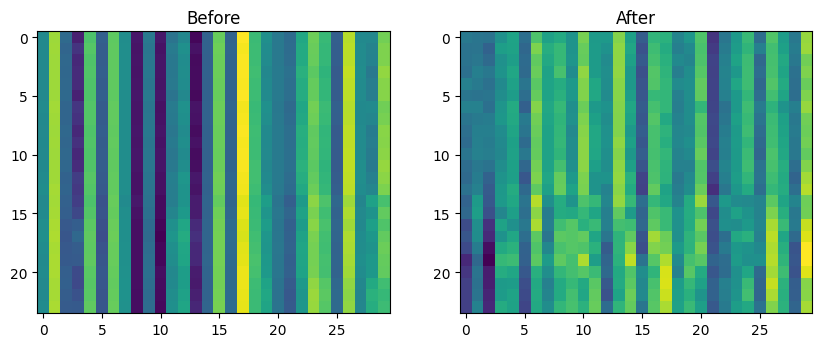

In [38]:
np_f1 = f1[2].detach().cpu().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(detach(c1_weights[3])[1000:1024, 30:60])
axs[0].set_title('Before')

axs[1].imshow(np_f1[1000:1024, 30:60])
axs[1].set_title('After')